In [1]:
import os
import getpass

from datasets import load_dataset
from huggingface_hub import login
from transformers import AutoTokenizer
from dotenv import load_dotenv
import matplotlib.pyplot as plt


In [2]:

load_dotenv('.envrc')
if 'HF_TOKEN' in os.environ:
    login(token=os.environ['HF_TOKEN'])
else:
    login(token=getpass.getpass('Huggingface token: '))

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [3]:
# DATASET_REPO = 'roneneldan/TinyStories'
# STORY_KEY = 'text'
DATASET_REPO = 'SimpleStories/SimpleStories'
STORY_KEY = 'story'

TOKENIZER_MODEL = 'SimpleStories/SimpleStories-35M'
VALIDATION_SPLIT_PERCENTAGE = 4

In [4]:

dataset = load_dataset(DATASET_REPO, split='train')
print('Total rows:', len(dataset))


Generating train split:   0%|          | 0/2115696 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/21371 [00:00<?, ? examples/s]

Total rows: 2115696


In [5]:
# tokenize the dataset  
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_MODEL)
tokenizer.pad_token = tokenizer.eos_token
def tokenize_function(examples):
    return tokenizer(examples[STORY_KEY], truncation=False, padding='do_not_pad')
tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=dataset.column_names)


Map:   0%|          | 0/2115696 [00:00<?, ? examples/s]

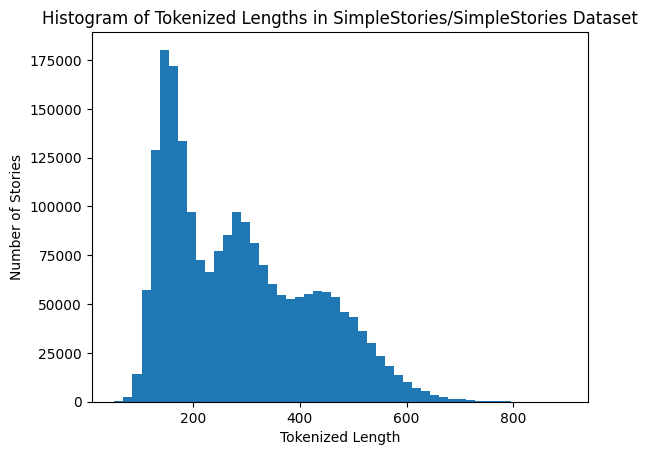

In [6]:
# Historgram of tokenized lengths
lengths = [len(x) for x in tokenized_dataset['input_ids']]
plt.hist(lengths, bins=50)
plt.xlabel('Tokenized Length')
plt.ylabel('Number of Stories')
plt.title(f'Histogram of Tokenized Lengths in {DATASET_REPO} Dataset')
plt.show()

In [7]:
for thresh in [64, 128, 256, 512]:
    x = sum(l >= thresh for l in lengths) / len(lengths) * 100
    print(f"{x}% of stories are at least {thresh} tokens")

99.9950370941761% of stories are at least 64 tokens
94.04508020055812% of stories are at least 128 tokens
52.60907049027838% of stories are at least 256 tokens
7.031728565918733% of stories are at least 512 tokens


In [8]:
CHUNK_LENGTH = 128
def chunk_dataset_with_map(dataset, token_column='input_ids', chunk_length=CHUNK_LENGTH):
    """
    Memory-efficient version using dataset.map() and batched processing.
    """
    
    def chunk_batch(batch):
        chunked_batch = {col: [] for col in batch.keys()}
        
        for i in range(len(batch[token_column])):
            tokens = batch[token_column][i]
            token_count = len(tokens)
            num_chunks = token_count // chunk_length
            
            for chunk_idx in range(num_chunks):
                start_idx = chunk_idx * chunk_length
                end_idx = start_idx + chunk_length
                chunk_tokens = tokens[start_idx:end_idx]
                
                # Add chunk to batch
                for col in batch.keys():
                    if col == token_column:
                        chunked_batch[col].append(chunk_tokens)
                    else:
                        chunked_batch[col].append(batch[col][i])
        
        return chunked_batch
    
    # Use map with batched=True for memory efficiency
    chunked_dataset = dataset.map(
        chunk_batch,
        batched=True,
        remove_columns=dataset.column_names,  # Remove original columns
        batch_size=1000,  # Adjust based on your memory constraints
    )
    
    return chunked_dataset
chunked_dataset = chunk_dataset_with_map(tokenized_dataset, chunk_length=CHUNK_LENGTH)

Map:   0%|          | 0/2115696 [00:00<?, ? examples/s]

In [9]:
print(f"The chunked dataset is {len(chunked_dataset)/len(tokenized_dataset) * 100}% of the original dataset length")
total_tokens_chunked = len(chunked_dataset)*CHUNK_LENGTH/1e6
total_tokens_original = sum(lengths)/1e6
print(f"Total available tokens = {total_tokens_original}M tokens")
print(f"Total tokens in chunked dataset = {total_tokens_chunked}M tokens")
print(f"We are left with {total_tokens_chunked/total_tokens_original * 100}% of the original tokens")

The chunked dataset is 179.8969228093261% of the original dataset length
Total available tokens = 608.617592M tokens
Total tokens in chunked dataset = 487.177216M tokens
We are left with 80.0465222175175% of the original tokens


In [10]:
split_dataset = chunked_dataset.train_test_split(test_size=VALIDATION_SPLIT_PERCENTAGE/100)
print(f"Train set size: {len(split_dataset['train'])} samples")
print(f"Validation set size: {len(split_dataset['test'])} samples")
split_dataset.push_to_hub(f"MikiV/{DATASET_REPO.replace('/', '-')}-chunked-{CHUNK_LENGTH}", private=True)

# chunked_dataset.push_to_hub(f"MikiV/{DATASET_REPO.replace('/', '-')}-chunked-{CHUNK_LENGTH}", private=True)


Train set size: 3653829 samples
Validation set size: 152243 samples


Uploading the dataset shards:   0%|          | 0/10 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/MikiV/SimpleStories-SimpleStories-chunked-128/commit/2ad45675eeb8d9b81afb1ce0d5c79d3f79dde6b7', commit_message='Upload dataset', commit_description='', oid='2ad45675eeb8d9b81afb1ce0d5c79d3f79dde6b7', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/MikiV/SimpleStories-SimpleStories-chunked-128', endpoint='https://huggingface.co', repo_type='dataset', repo_id='MikiV/SimpleStories-SimpleStories-chunked-128'), pr_revision=None, pr_num=None)